<a href="https://colab.research.google.com/github/wakamatsuikuma/MEMO_causal_analysis_by_python/blob/main/%E7%AC%AC5%E7%AB%A0_2_Meta_learners(T_Learners%2C_S_Learner%2C_X_Learner)%E3%81%AE%E5%AE%9F%E8%A3%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# メモ
【X-Leanerによる介入効果の推定】
1. まず介入有り無しでデータを分ける  
2. それぞれのデータセットで、結果変数と共変量(原因変数(=介入)以外)でモデル構築  
3. それぞれのデータセットとモデル推定値の各サンプルにおいて、ITTとITUを求める
ITU ＝ 介入有りモデル(介入無し共変量) -  介入無し結果変数  
ITT ＝ 介入有り結果変数 - 介入無しモデル(介入有り共変量)  
　　（ATU = ITU.mean(),、ATT = ITT.mean()）  
4. 各データセットの共変量を説明変数、上記ITTおよひITUを目的変数として、モデル構築  
　　　ITUモデル = model.fit(介入無し共変量, ITU)  
　　　ITTモデル = model.fit(介入有り共変量, ITT)  
5. 上記の各モデルを全データの共変量を使って、ITT(hat)とITE(hat)を推定  
　　　ITU(hat) = ITUモデル(全データの共変量)  
　　　ITT(hat) = ITTモデル(全データの共変量)  
6. 原因変数と共変量で傾向スコア( g(x) : 介入有りの確率)算出
7. 各効果の推定値を傾向スコアで調整
ITE = g(x) * ITU(hat) + ( 1 - g(x) ) * ITT(hat)  
ATE = ITE.mean()  
　　　（反実仮想側の傾向スコアを重みづけることで、介入の有り無しについてよりフラットな状況を考えているということ？）  

【T-Learnrによる介入効果の推定】
1. まず介入有り無しでデータを分ける  
2. それぞれのデータで、結果変数と共変量(原因変数(=介入)以外)でモデル構築  
3. それぞれのモデルで、介入有り無し分割前の共変量(原因変数(=介入)以外)で結果変数の推定  
　介入有りの推定値：mu_1  
　介入無しの推定値：mu_2  
4. 各サンプルにおける各モデルの推定値の差がITE、ITEの平均がATE  
ITE ＝ mu_1(i) - mu_2(i)  
ATE(平均) ＝ ATE(i).mean()  

+α
- ITTとITUも求められる  
ITT ＝ 介入有り結果変数 - 介入無しモデル(介入有り共変量)  
ITU ＝ 介入有りモデル(介入無し共変量) -  介入無し結果変数  

【S-Learnerによる介入効果の推定】  
1. 結果変数と共変量+原因変数の全データでモデル構築
2. 介入が全て有り or 無しとして置き換えたデータセットを作成  
　　X_0 : 介入を全て無しに置き換えた原因変数+共変量  
　　X_1 : 介入を全て有りに置き換えた原因変数+共変量
3.  ITE = モデル(X_1) - モデル(X_0)
4. ATE = ITE.mean()  


# 5.2 Meta-learners（T-Learner、S-Learner、X-Learner）の実装

## ライブラリのインポート、設定

In [ ]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)

# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd


# データの生成

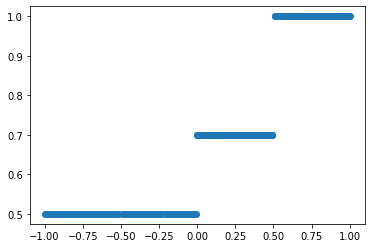

In [ ]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(5.0*x+5*e_z)  # xの効果が反対になっていたのを修正Issue：#18
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")


## データをまとめた表を作成し、可視化する

x    Z    t         Y
0 -0.616961  0.0  0.5  1.803183
1  0.244218  1.0  0.7  2.668873
2 -0.124545  0.0  0.5  2.193123
3  0.570717  1.0  1.0  3.245229
4  0.559952  1.0  1.0  3.139868

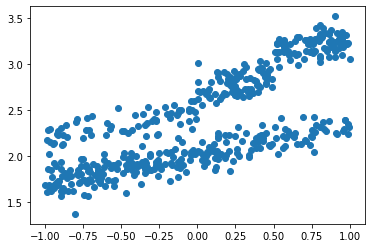

In [ ]:
# データ表を作成
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

display(df.head())  # 先頭を表示

plt.scatter(x, Y)

## T-Learner

In [ ]:
# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団


In [ ]:
df

x    Z    t         Y
0   -0.616961  0.0  0.5  1.803183
1    0.244218  1.0  0.7  2.668873
2   -0.124545  0.0  0.5  2.193123
3    0.570717  1.0  1.0  3.245229
4    0.559952  1.0  1.0  3.139868
..        ...  ...  ...       ...
495 -0.464863  0.0  0.5  1.904801
496  0.865654  1.0  1.0  3.242518
497  0.652290  1.0  1.0  3.290957
498 -0.709114  1.0  0.5  2.279574
499  0.294007  0.0  0.7  2.168089

[500 rows x 4 columns]

In [ ]:
df_0

x    Z    t         Y
0   -0.616961  0.0  0.5  1.803183
2   -0.124545  0.0  0.5  2.193123
5   -0.454815  0.0  0.5  1.973293
6   -0.447071  0.0  0.5  1.953387
9    0.751865  0.0  1.0  2.289369
..        ...  ...  ...       ...
492 -0.309042  0.0  0.5  2.028327
493  0.183443  0.0  0.7  2.228075
494 -0.541893  0.0  0.5  1.739014
495 -0.464863  0.0  0.5  1.904801
499  0.294007  0.0  0.7  2.168089

[262 rows x 4 columns]

In [ ]:
df_1

x    Z    t         Y
1    0.244218  1.0  0.7  2.668873
3    0.570717  1.0  1.0  3.245229
4    0.559952  1.0  1.0  3.139868
7    0.603744  1.0  1.0  3.099174
8    0.916279  1.0  1.0  3.337863
..        ...  ...  ...       ...
484 -0.035676  1.0  0.5  2.502142
485  0.536158  1.0  1.0  3.134568
496  0.865654  1.0  1.0  3.242518
497  0.652290  1.0  1.0  3.290957
498 -0.709114  1.0  0.5  2.279574

[238 rows x 4 columns]

In [ ]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# 介入を受けていないモデル
reg_0 = RandomForestRegressor(max_depth=3)
reg_0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
reg_1 = RandomForestRegressor(max_depth=3)
reg_1.fit(df_1[["x"]], df_1[["Y"]])


<ipython-input-8-ae2d8584ca4a>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_0.fit(df_0[["x"]], df_0[["Y"]])
<ipython-input-8-ae2d8584ca4a>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_1.fit(df_1[["x"]], df_1[["Y"]])


RandomForestRegressor(max_depth=3)

In [ ]:
# ATEを求める
mu_0 = reg_0.predict(df[["x"]])
mu_1 = reg_1.predict(df[["x"]])

ATE = (mu_1-mu_0).mean()
print("ATE：", ATE)

ATE： 0.6678485877933638


In [ ]:
mu_0.shape

(500,)

In [ ]:
# 処置群における平均処置効果ATTと、対照群における平均処置効果ATU
ATT = df_1["Y"] - reg_0.predict(df_1[["x"]])
ATU = reg_1.predict(df_0[["x"]]) - df_0["Y"]

print("ATT：", ATT.mean())
print("ATU：", ATU.mean())


ATT： 0.7338369884256869
ATU： 0.6090862934128768


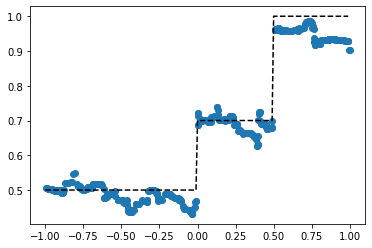

In [ ]:
# 推定された介入効果を各人ごとに求めます
# t_estimated = reg_1.predict(df[["x"]]) - reg_0.predict(df[["x"]])
t_estimated = mu_1 - mu_0 # こっちでもいいよね

plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0


# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

T-Learnerによる介入効果の推定 :  
まず介入有る無しでデータを分ける  
それぞれのデータで、結果変数と共変量(原因変数(=介入)以外)でモデル構築  
それぞれのモデルで、介入有り無し分割前の共変量(原因変数(=介入)以外)で結果変数の推定  
各モデルの推定値の差が各サンプルに対する介入効果、その推定値の平均がATE  




## S-Learner

In [ ]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# モデルを学習
reg = RandomForestRegressor(max_depth=4)
X = df.loc[:, ["x", "Z"]]
reg.fit(X, df[["Y"]])

<ipython-input-13-77ab71ca1d24>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X, df[["Y"]])


RandomForestRegressor(max_depth=4)

In [ ]:
# 処置が0と1の状態を作成する
X_0 = X.copy()
X_0["Z"] = 0.0

X_1 = X.copy()
X_1["Z"] = 1.0

# ATEの計算
ATE = (reg.predict(X_1)-reg.predict(X_0)).mean()
print("ATE：", ATE)


ATE： 0.667734812161322


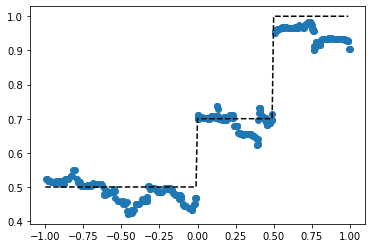

In [ ]:
# 推定された治療効果を各人ごとに求めます
t_estimated = reg.predict(X_1)-reg.predict(X_0)
plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')


## X-Learner

In [ ]:
# T-LearnerでM0とM1を求める
from sklearn.ensemble import RandomForestRegressor

# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団

# 介入を受けていないモデル
M0 = RandomForestRegressor(max_depth=3)
M0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
M1 = RandomForestRegressor(max_depth=3)
M1.fit(df_1[["x"]], df_1[["Y"]])

<ipython-input-16-528f8702eeab>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M0.fit(df_0[["x"]], df_0[["Y"]])
<ipython-input-16-528f8702eeab>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  M1.fit(df_1[["x"]], df_1[["Y"]])


RandomForestRegressor(max_depth=3)

In [ ]:
# 推定された治療効果を各人ごとに求めます
# tau_0 = reg_1.predict(df_0[["x"]]) - df_0["Y"]
# tau_1 = df_1["Y"] - reg_0.predict(df_1[["x"]])

# Issue 38ご指摘で判明：修正（2022/04/11）
tau_0 = M1.predict(df_0[["x"]]) - df_0["Y"]
tau_1 = df_1["Y"] - M0.predict(df_1[["x"]])


# ATTとATUを求めるモデルを作成します
M2 = RandomForestRegressor(max_depth=3)
M2.fit(df_0[["x"]], tau_0)

M3 = RandomForestRegressor(max_depth=3)
M3.fit(df_1[["x"]], tau_1)

RandomForestRegressor(max_depth=3)

In [ ]:
# 傾向スコアを求めます
from sklearn.linear_model import LogisticRegression

# 説明変数
X = df[["x"]]

# 被説明変数（目的変数）
Z = df["Z"]

# 回帰の実施
g_x = LogisticRegression().fit(X, Z)
g_x_val = g_x.predict_proba(X)

In [ ]:
# それぞれのモデルで全データの効果を予測し、傾向スコアで調整
tau = g_x_val[:, 1]*M2.predict(df[["x"]]) + g_x_val[:, 0]*M3.predict(df[["x"]])

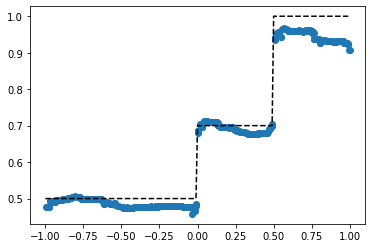

In [ ]:
# 推定された治療効果を各人ごとに求めます
plt.scatter(df[["x"]], tau, label="estimated_treatment-effect")

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')
